# Finite State Machine Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import (pprint as pp, pformat as pf)
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import dmyplant2
dmyplant2.cred()
mp = dmyplant2.MyPlant(3600)

### Filter Engines from installed fleet 

In [2]:
def sfun(x):
    return (
        ("Forsa Hartmoor" in str(x['IB Site Name'])) and 
        (x['OperationalCondition'] != 'Decommissioned'))
res = mp.search_installed_fleet(sfun)
res = res.sort_values(by = "Engine ID",ascending=True)
res.T;

In [3]:
dval = mp.def_from_installed_fleet(res)
dval.T

Loading Myplant Data: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 4007.06 engines/s]


,0,1,2,3,4,5,6,7,8,9,10
n,0,1,3,2,4,5,7,6,8,9,10
Validation Engine,Forsa Hartmoor M01,Forsa Hartmoor M02,Forsa Hartmoor M03,Forsa Hartmoor M04,Forsa Hartmoor M05,Forsa Hartmoor M06,Forsa Hartmoor M07,Forsa Hartmoor M08,Forsa Hartmoor M09,Forsa Hartmoor M10,Forsa Hartmoor M11
serialNumber,1486144,1486152,1486176,1486174,1486197,1486198,1486236,1486225,1486251,1486255,1486272
val start,2022-01-10 00:00:00,2022-01-10 00:00:00,2022-01-11 00:00:00,2022-01-11 00:00:00,2022-01-22 00:00:00,2022-01-10 00:00:00,2022-01-11 00:00:00,2022-01-11 00:00:00,2022-01-11 00:00:00,2022-01-22 00:00:00,2022-01-11 00:00:00
oph@start,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
starts@start,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
Asset ID,159396.0,159397.0,159399.0,159398.0,159400.0,159401.0,159403.0,159402.0,159404.0,159405.0,159406.0


In [4]:
# Ammerlaan Flowers 2, J420 Frage von David Sepulveda Lopez
#e=dmyplant2.Engine.from_sn(mp,5640011)
dval.iloc[5]['serialNumber']
e=dmyplant2.Engine.from_sn(mp,dval.iloc[5]['serialNumber'])

In [5]:
pd.DataFrame.from_dict(e.dash, orient='index').T

,Name,Engine ID,Design Number,Engine Type,Engine Version,P,P_nom,BMEP,serialNumber,id,Count_OpHour,val start,oph@start,oph parts,LOC
0,Forsa Hartmoor M06,M06,AL89,624,H12,24,4582.1,24.5,1486198,159401,180.0,2022-01-10,57,123,0.1695


In [6]:
from dfsm import msgFSM
fsm_data = []
#fsm = msgFSM(e, skip_day=7)
#fsm = msgFSM(e, p_from='2022-01-11')
fsm = msgFSM(e)
fsm.run() # run Finite State Machine
fsm_data.append({'engine':e, 'fsm':fsm})

Using '9047 target load reached' Message.


FSM: 100%|███████████████████████| 10558/10558 [00:04<00:00, 2265.39 messages/s]


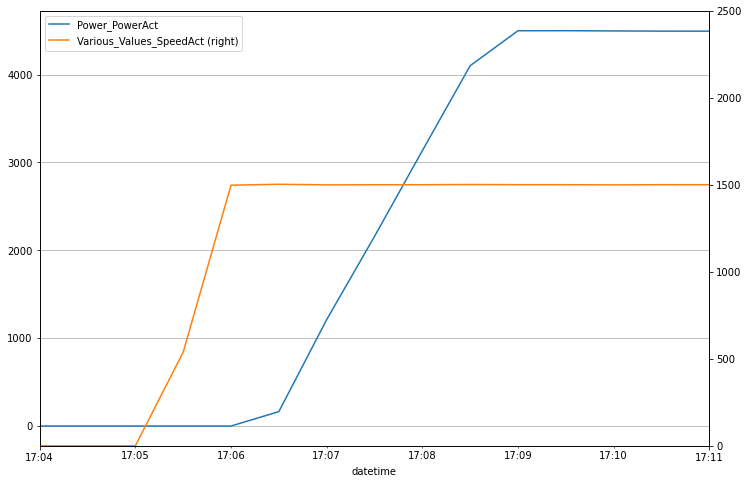

In [7]:
fsm.plot_ts(1637687335601, figsize=(12,8));
plt.show()

In [8]:
res = fsm_data[0]
res['result'] = pd.DataFrame(fsm_data[0]['fsm']._starts)
print(f"""
*****************************************
** {str(res['engine'])} **
*****************************************""")
print(f"{'Meldung':9} '{'9047 target load reached'}' {'gefunden.' if any(res['fsm']._messages['name'] == '9047') else 'wird berechnet.'}")
print(f"{'Zeitraum':9}: {res['fsm'].first_message:%d.%m.%Y} bis {res['fsm'].last_message:%d.%m.%Y}")
print(f"{'Dauer':9}: {res['fsm'].period.days:5} Tage")
print(f"{'GESAMT':9}: {res['result'].shape[0]:5} Starts, {res['result'][res['result'].success].shape[0]:5} erfolgreich => {(res['result'][res['result'].success].shape[0] / res['result'].shape[0]) * 100.0:3.1f} % der Starts erfolgreich.")
for mode in ['???','OFF','MANUAL', 'AUTO']:
    lstarts = res['result'][res['result']['mode'] == mode].shape[0]
    successful_starts = res['result'][((res['result'].success) & (res['result']['mode'] == mode))].shape[0]
    print(f"{mode:9}: {lstarts:5} Starts, {successful_starts:5} erfolgreich => {(successful_starts / lstarts) * 100.0 if lstarts != 0 else 0.0:3.1f} % der Starts erfolgreich.")
#res['filtered_result'][['start-preparation','starter','hochlauf','idle','synchronize','cumstarttime','load-ramp','target-operation']].hist(figsize = (20,12), bins=50, layout=(3,3));


*****************************************
** 1486198 Forsa Hartmoor M06 **
*****************************************
Meldung   '9047 target load reached' gefunden.
Zeitraum : 03.11.2021 bis 21.02.2022
Dauer    :   110 Tage
GESAMT   :   131 Starts,    77 erfolgreich => 58.8 % der Starts erfolgreich.
???      :     0 Starts,     0 erfolgreich => 0.0 % der Starts erfolgreich.
OFF      :     4 Starts,     2 erfolgreich => 50.0 % der Starts erfolgreich.
MANUAL   :    30 Starts,     4 erfolgreich => 13.3 % der Starts erfolgreich.
AUTO     :    97 Starts,    71 erfolgreich => 73.2 % der Starts erfolgreich.


In [9]:
rdf = res['result']
# filter als pleased :-)
#rda = rdf
#rda = rdf[((rdf['mode'] == 'AUTO') & (rdf['success'] == True))]
#rda = rdf[((rdf['mode'] == 'AUTO') & (rdf['success'] == True) & (rdf['synchronize'] < 300.0) & (rdf['start-preparation'] < 300.0))]
#rda = rdf[((rdf['success'] == True) & (rdf['start-preparation'] < 1000.0))]
rda = rdf[((rdf['success'] == True))]
rda[fsm.filter_content].round(2);

In [10]:
rda.describe().round(2).T;

In [11]:
longer_than_300s = rda[fsm.filter_period + fsm.filter_content][rdf['cumstarttime'] > 300.0]
longer_than_300s[fsm.filter_content].round(2);

In [12]:
#for i, r in longer_than_300s.iterrows():
#    fsm.plot_cycle(r, max_length=20*60, ylim=(0,5000), title=f"{fsm._e}{r['starttime'].round('S')}: cumstarttime: {r['cumstarttime']}s");

In [13]:
longer_than_300s.describe().round(2).T;

In [14]:
load_ramp_less_than_100s = rda[fsm.filter_period + fsm.filter_content][rdf['load-ramp'] < 100.0]
lfsm = load_ramp_less_than_100s[fsm.filter_content].reset_index(drop='index').round(2)
lfsm

,success,mode,cumstarttime,start-preparation,starter,hochlauf,idle,synchronize,load-ramp,target-operation
0,True,MANUAL,223.88,76.96,3.94,22.42,6.87,55.66,58.03,0 days 00:11:34
1,True,AUTO,181.82,78.68,3.74,27.24,6.86,7.47,57.83,0 days 08:43:06
2,True,AUTO,236.81,137.66,4.03,19.87,5.55,12.10,57.60,0 days 02:34:16
3,True,OFF,160.47,64.87,4.34,26.73,7.16,16.34,41.04,0 days 00:06:05
4,True,AUTO,256.94,165.95,3.53,9.59,6.37,27.42,44.08,0 days 00:26:19
5,True,AUTO,260.49,135.99,3.73,22.40,7.06,20.72,70.58,0 days 00:10:21
6,True,AUTO,191.07,60.64,4.23,19.69,5.95,28.95,71.59,0 days 00:02:19
7,True,AUTO,254.59,165.03,4.03,21.38,5.14,11.31,47.70,0 days 00:06:43


In [15]:
r = load_ramp_less_than_100s.reset_index(drop='index').iloc[0]
r_summary = pd.DataFrame(r[fsm.filter_times], dtype=np.float64).round(2).T
r_summary

,start-preparation,starter,hochlauf,idle,synchronize,load-ramp
0,76.96,3.94,22.42,6.87,55.66,58.03


Load Data: 50000 datarows [00:00, 110976.16 datarows/s]                         


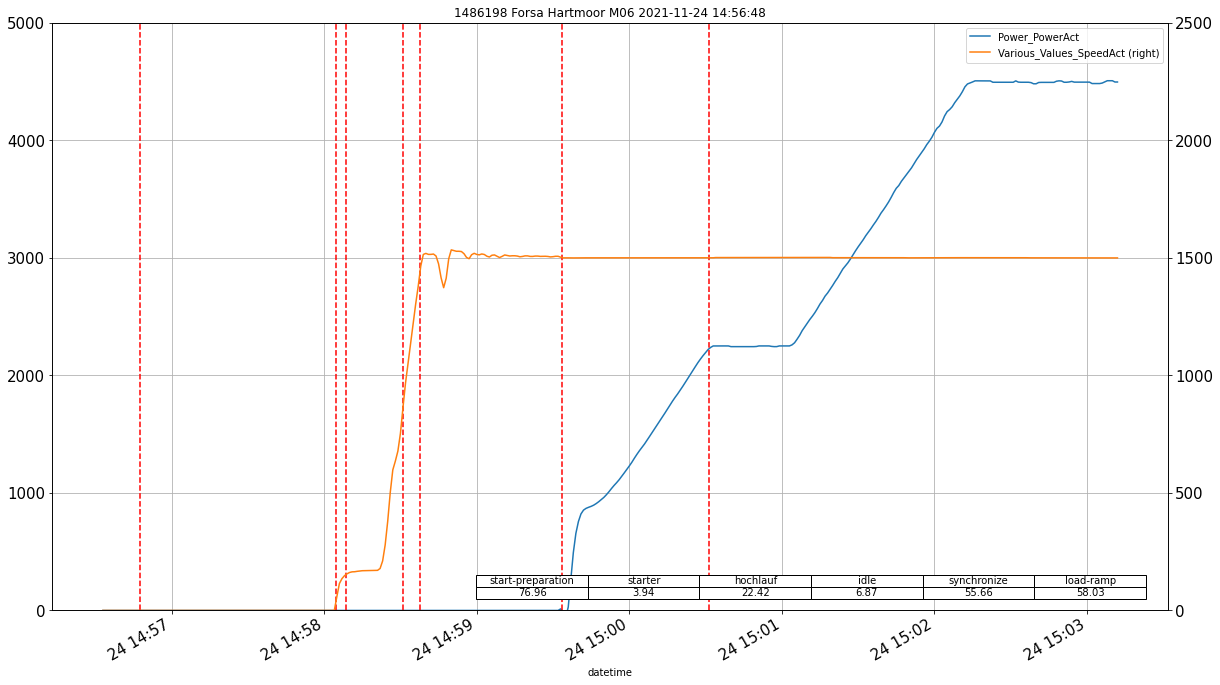

In [17]:
fsm.plot_cycle(r, max_length=400, ylim=(0,5000), cycletime=1, marker=None, figsize=(20,12), fontsize=15, title=f"{fsm._e} {r['starttime'].round('S')}");
plt.show()

Load Data: 50000 datarows [00:02, 24920.12 datarows/s]                          


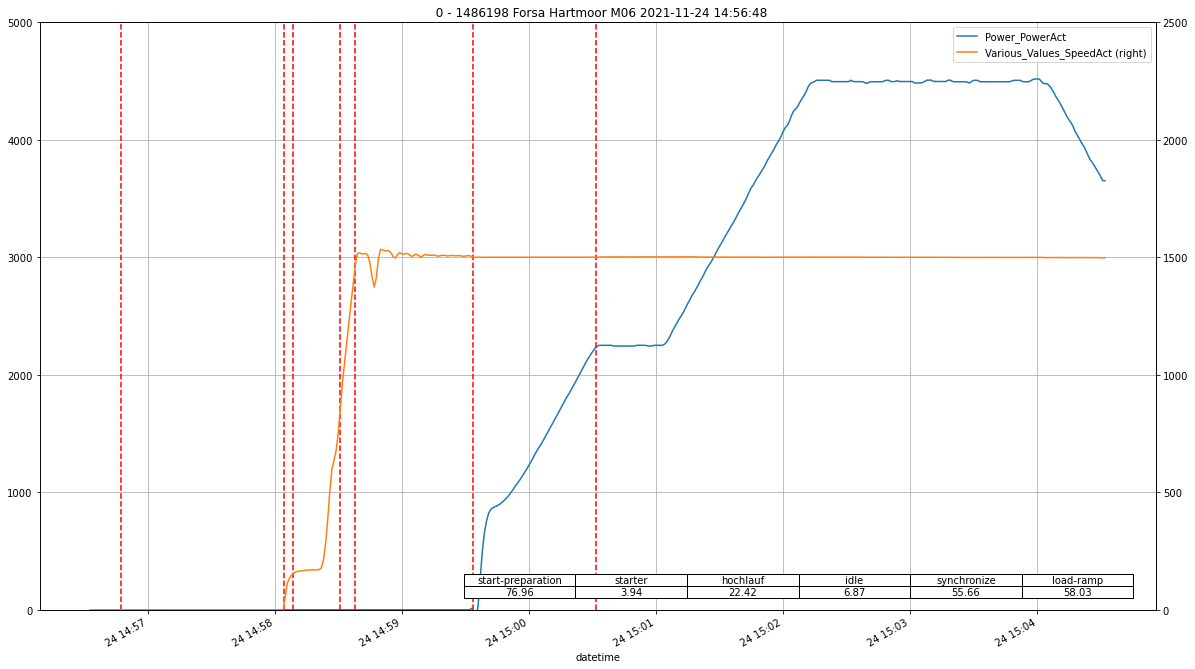

Load Data: 100000 datarows [00:04, 23418.52 datarows/s]                         


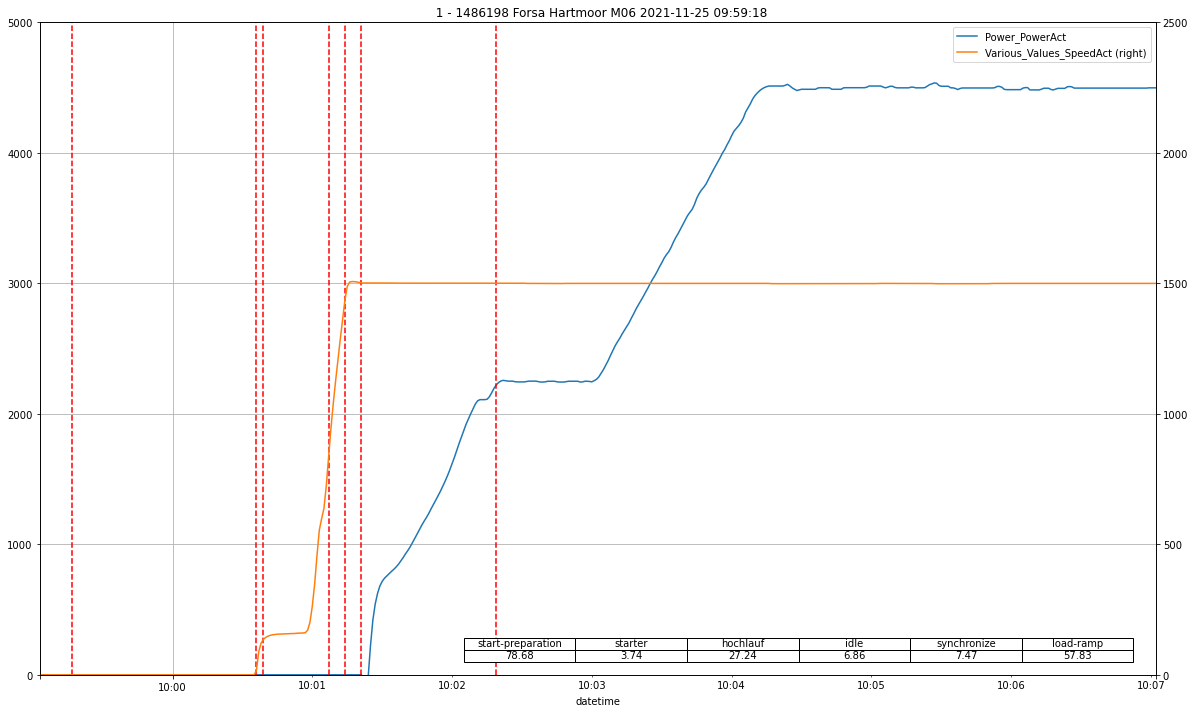

Load Data: 550000 datarows [00:26, 20691.40 datarows/s]                         


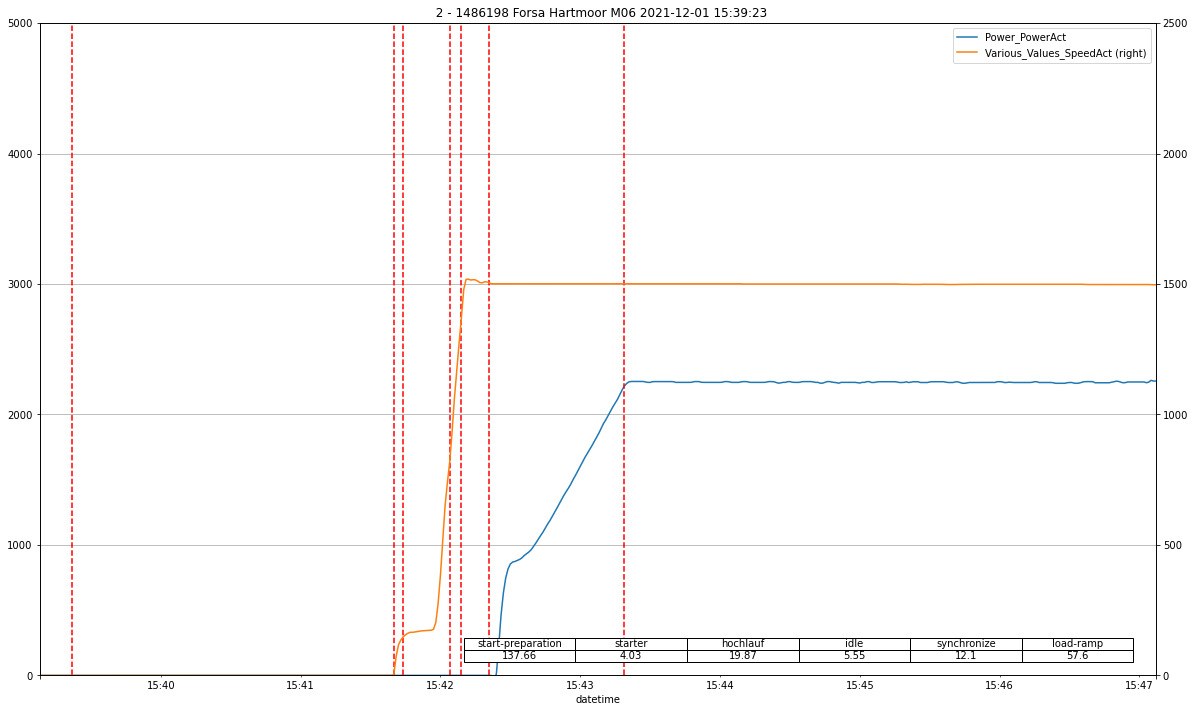

Load Data: 650000 datarows [00:29, 21794.99 datarows/s]                         


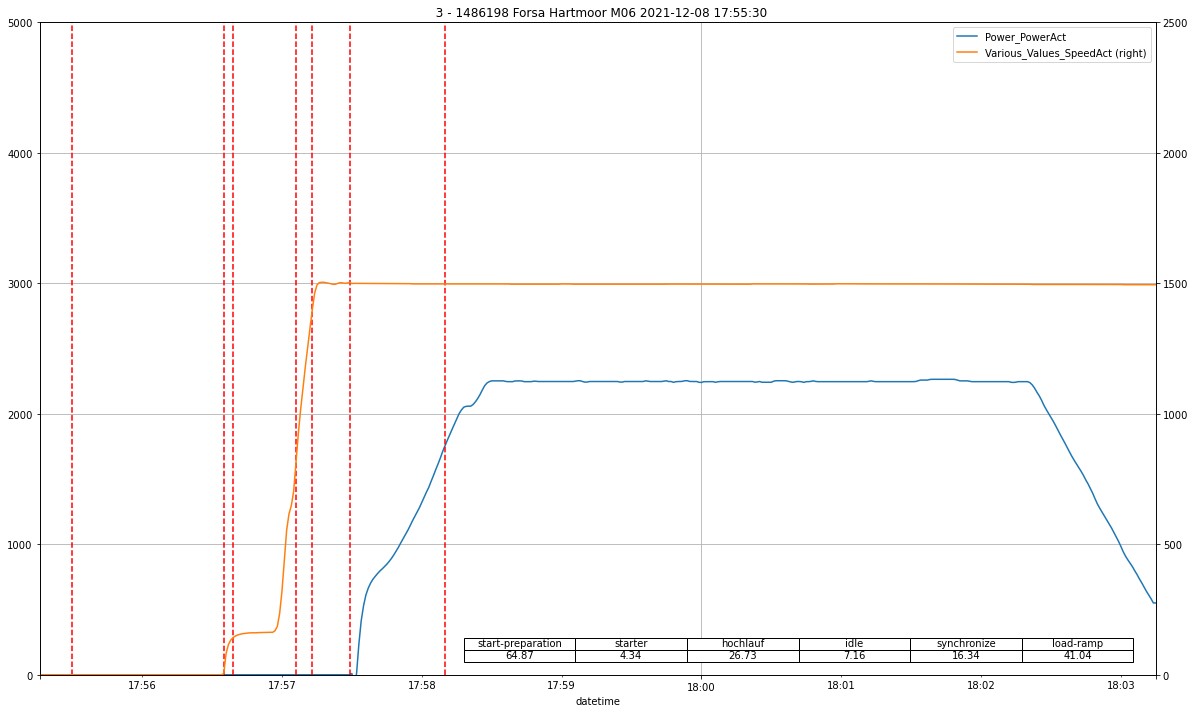

Load Data: 50000 datarows [00:00, 124739.89 datarows/s]                         


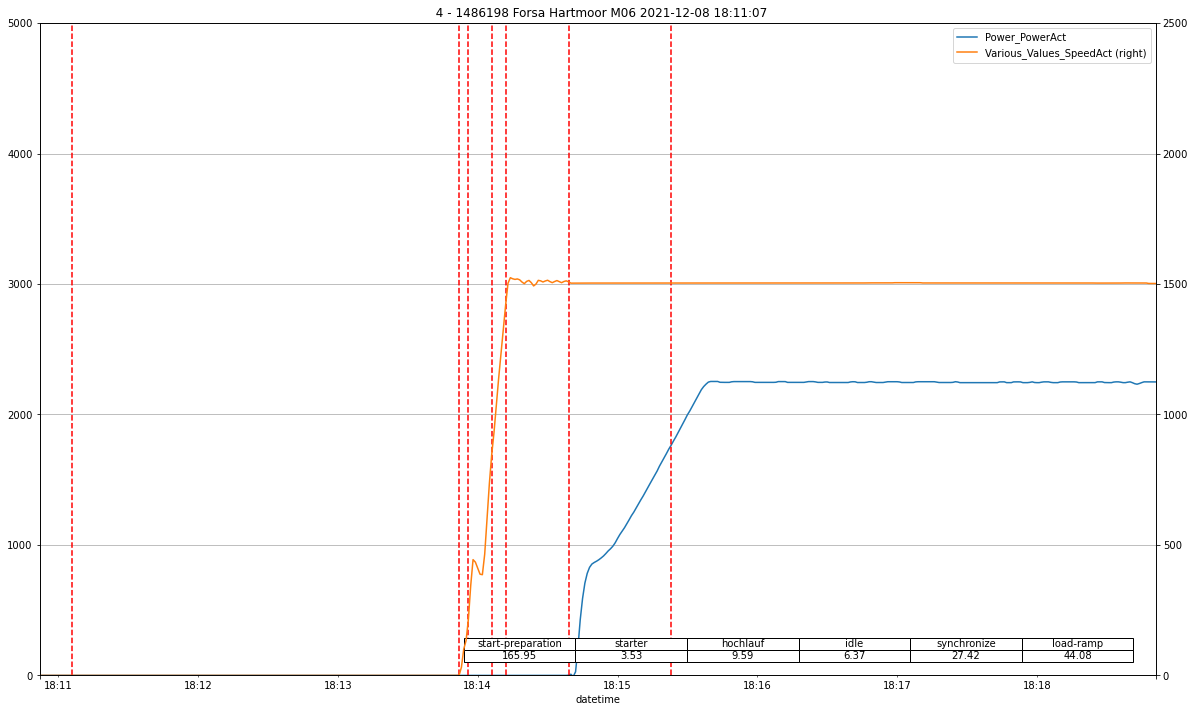

Load Data: 2550000 datarows [02:19, 18323.18 datarows/s]                        


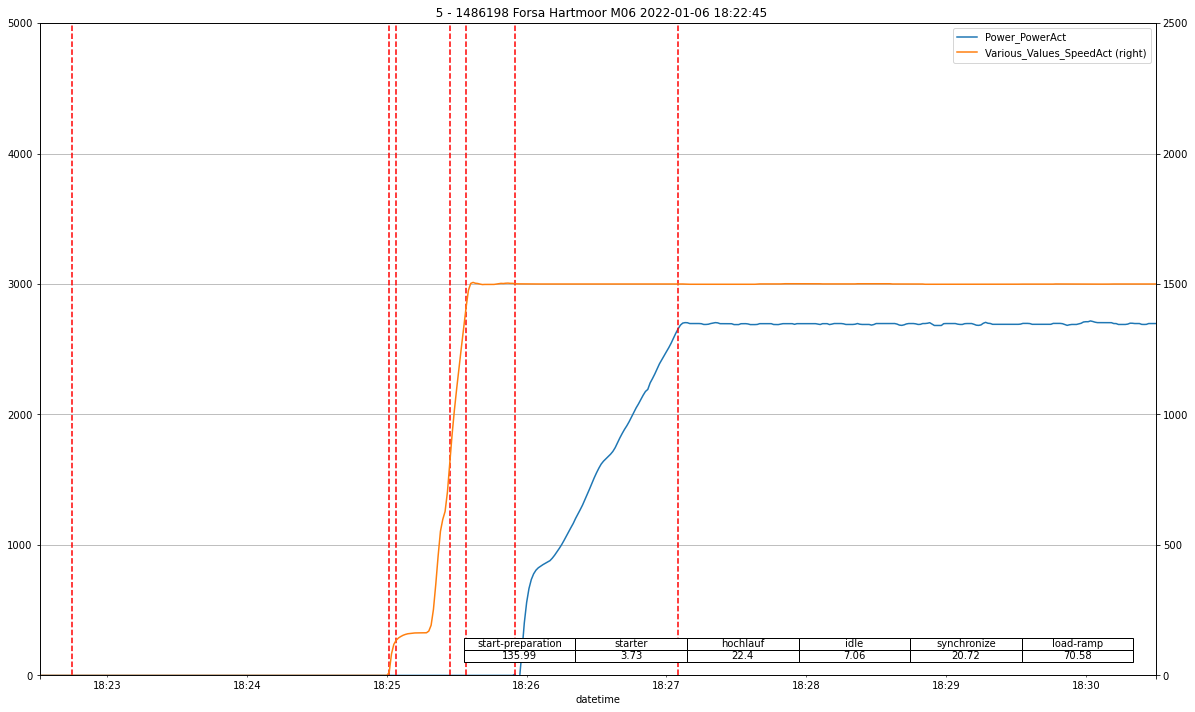

Load Data: 50000 datarows [00:01, 48363.92 datarows/s]                          


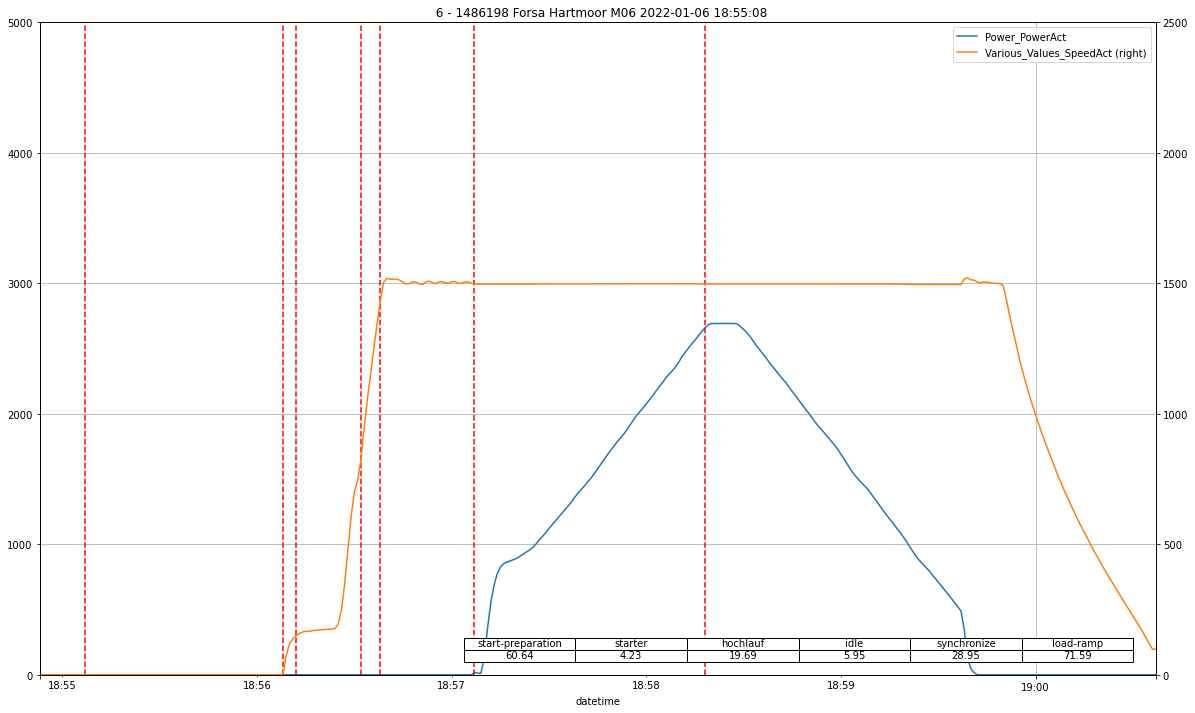

Load Data: 3300000 datarows [03:18, 16646.10 datarows/s]                        


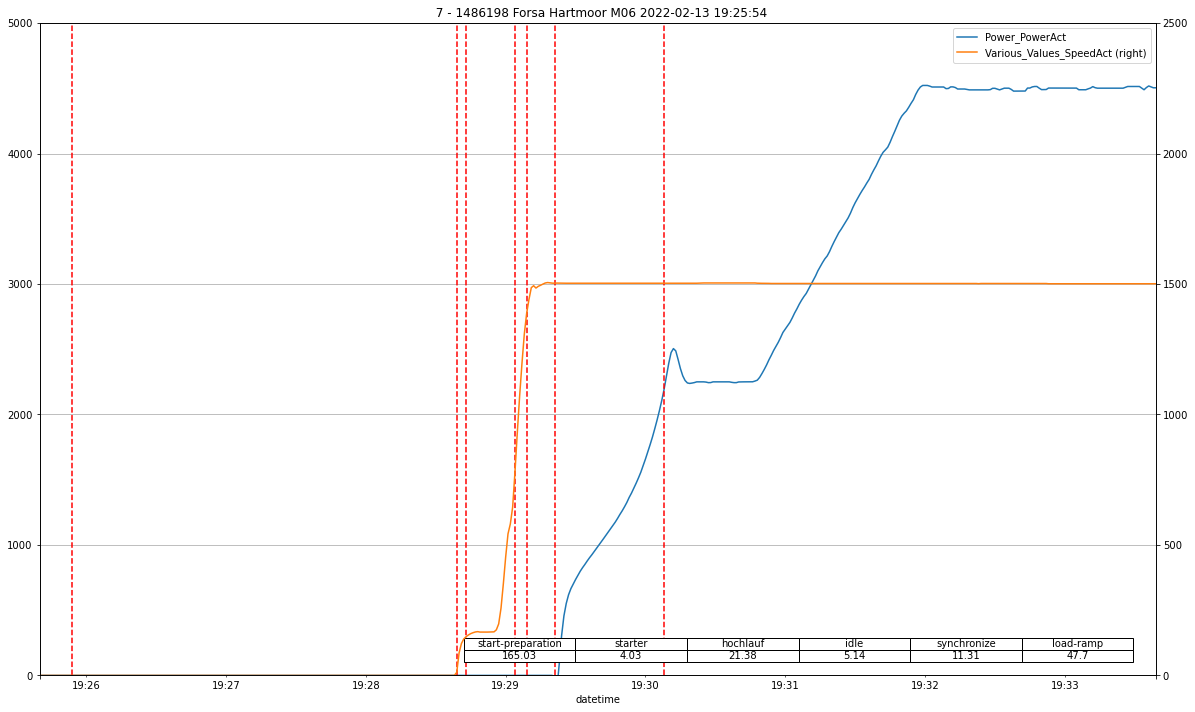

In [18]:
for i, r in load_ramp_less_than_100s.reset_index(drop='index').iterrows():
    fsm.plot_cycle(r, max_length=8*60, ylim=(0,5000), cycletime=1, marker=None,figsize=(20,12), title=f"{i:3d} - {fsm._e} {r['starttime'].round('S')}")
    plt.show()


In [ ]:
load_ramp_less_than_100s.describe().round(2).T

In [ ]:
rda[['start-preparation','starter','hochlauf','idle','synchronize','cumstarttime','load-ramp','target-operation']].hist(figsize = (20,12), bins=50, layout=(3,3));
#rda.hist(figsize = (20,12), bins=100, layout=(4,2));

In [ ]:
#rda.plot.box(subplots=True, grid = True, figsize=(24,10), layout=(1,7));
#rda.plot.box(subplots=True, grid = True, figsize=(24,10), layout=(1,7), sym='');

In [ ]:
nalarms = []
ct = 0
for i,c in rdf.iterrows():
    if len(c['alarms']) > 0 and not c['success']:
        ct += 1
        print(f"\nStartversuch: {i}, Success: {c['success']}")
        for a in c['alarms']:
            nalarms.append(a['msg'])
            print(f"{c['mode']:15} {a['state']:20} {a['msg']['timestamp']} {pd.to_datetime(int(a['msg']['timestamp'])*1e6).strftime('%d.%m.%Y %H:%M:%S')} {a['msg']['name']} {a['msg']['message']}")
print(f"""
***********************************
** {ct:3} nicht erfolgreiche Starts **
***********************************
""")

In [ ]:
al = pd.DataFrame(fsm._pareto(nalarms))
fig = plt.figure();
color = 'purple'

if not al.empty:
    al['msg'] = al['msg'] + ' (' + al['name'] + ')'
    al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title='Alarms in not successful Starts');
    plt.plot();

In [ ]:
phases = [['start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation'],'start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation']
fig = plt.figure();
color = 'red'

for phase in phases:
    al = fsm.alarms_pareto(phase)[:30]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


In [ ]:
phases = [['start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation'],'start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation']
fig = plt.figure();
color = 'orange'

for phase in phases:
    al = fsm.warnings_pareto(phase)[:30]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


In [ ]:
mfn = './data/' + str(e._sn) + '_messages.txt'
fsm.save_messages('./data/' + str(e._sn) + '_messages.txt')
print(mfn)

In [ ]:
any(fsm._messages['name'] == '9047')

In [ ]:
#fsm.store()